In [1]:
!pip install imbalanced-learn xgboost gradio kagglehub

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Dataset downloaded at:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded at: /kaggle/input/creditcardfraud


In [3]:
import pandas as pd

df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


In [5]:
print(df.info())
print("\nClass Distribution:\n", df['Class'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

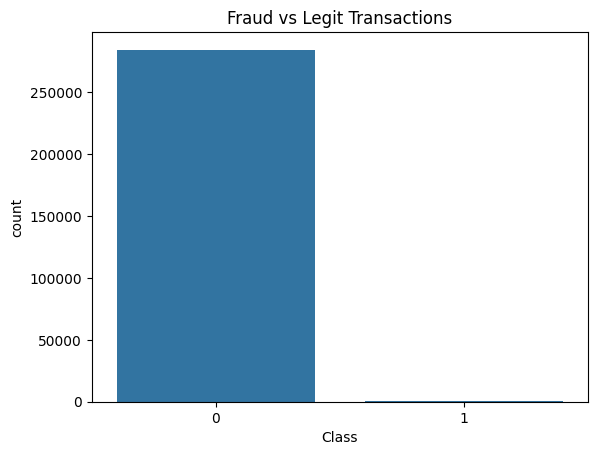

In [6]:
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Legit Transactions")
plt.show()


In [7]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df.drop('Time', axis=1, inplace=True)


In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 Class
0    227451
1       394
Name: count, dtype: int64

After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression\n", classification_report(y_test, y_pred_lr))


Logistic Regression
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962



In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
print("Random Forest\n", classification_report(y_test, y_pred_rf))


Random Forest
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_res, y_train_res)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.87      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



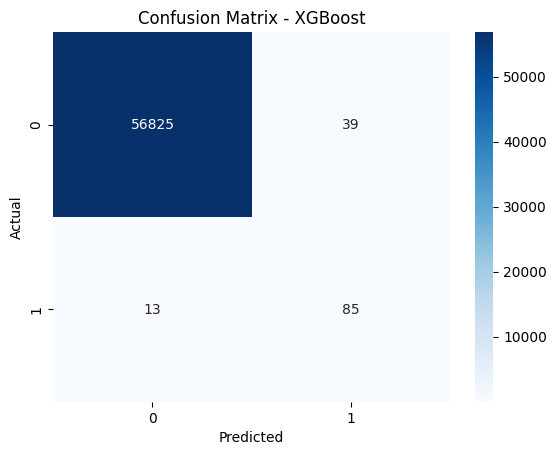

In [13]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


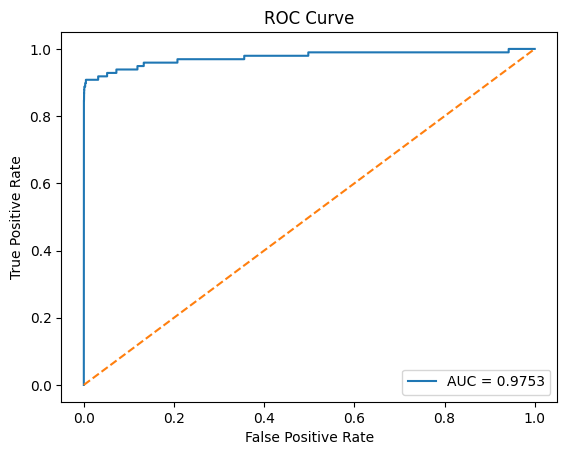

In [14]:
y_probs = xgb.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [16]:
import gradio as gr
import numpy as np

def predict_fraud_from_vector(input_text):
    try:
        # Convert string to list of floats
        values = [float(x.strip()) for x in input_text.split(",")]

        if len(values) != 29:
            return f"❌ Error: Expected 29 values (V1–V28 + Amount), got {len(values)}"

        data = np.array(values).reshape(1, -1)
        prediction = xgb.predict(data)[0]

        if prediction == 1:
            return "🚨 Fraudulent Transaction Detected"
        else:
            return "✅ Legitimate Transaction"

    except Exception as e:
        return f"❌ Invalid input format: {str(e)}"

gr.Interface(
    fn=predict_fraud_from_vector,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter V1, V2, V3, ..., V28, Amount (comma-separated)",
        label="Transaction Feature Vector"
    ),
    outputs=gr.Textbox(label="Prediction"),
    title="💳 Credit Card Fraud Detection System",
    description=(
        "Enter all transaction features at once as a comma-separated list.\n\n"
        "Example:\n"
        "0.12, -1.23, 0.45, ..., 1.02, 0.89"
    )
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa0c2ae0b983b418a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
